In [134]:
from typing import TypedDict, Annotated, List, Dict, Optional

import operator


class FinancialData(TypedDict):
    ratios: Dict
    earnings_trend: str

class SentimentData(TypedDict):
    score: float
    summary: str
class InvestmentState(TypedDict):
    ticker: str
    messages: Annotated[List[str],operator.add]
    fundamental_data: Optional[FinancialData]
    Sentiment_data: Optional[SentimentData]
   

    current_step: str
    is_debated: bool


In [135]:
import yfinance as yf

In [136]:
import os
from dotenv import load_dotenv

# 1. Load the variables from .env into the environment
load_dotenv()

# 2. Retrieve the key
api_key = os.getenv("OPEN_API_KEY")

if not api_key:
    raise ValueError("API Key not found. Please set it in the .env file.")

print("Key loaded successfully!")

Key loaded successfully!


In [137]:
###{'pe_ratio': 33.4488, 'debt_to_equity': 102.63, 'revenue_growth': 0.157###

In [138]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

In [139]:
from langchain_community.tools import YahooFinanceNewsTool
from langchain.tools import tool
import yfinance as yf

@tool
# Define custom tools for the agent to use
def get_fundamental_metrics(ticker: str):
    """Fetches P/E, Debt-to-Equity, and Revenue Growth for a given ticker."""
    stock = yf.Ticker(ticker)
    info = stock.info
    
    return {
        "pe_ratio": info.get("trailingPE"),
        "debt_to_equity": info.get("debtToEquity"),
        "revenue_growth": info.get("revenueGrowth"),
    }

# Combine tools
tools = [get_fundamental_metrics]

from langchain_openai import ChatOpenAI

# Initialize the LLM with tool binding
llm = ChatOpenAI(model="gpt-4o",api_key=api_key).bind_tools(tools)
def fundamental_analyst_node(state :InvestmentState):
    ticker= state['ticker']

    prompt=f""" 
You are an expert Fundamental Analyst. Analyze the financial metrics for {ticker}

1. Use the 'get_fundamental_metrics' tool to retrieve current data.

2. Assess the financial health based on P/E and Debt/Equity.

3. Return a concise, structure analysis.


 """
    
    response= llm.invoke([("system", prompt),("human" , f"Analyze {ticker}")])

    if response.tool_calls:
    # 3. Execute the tool (yfinance logic)
        tool_name = response.tool_calls[0]["name"]
        tool_args = response.tool_calls[0]["args"]
    
    # Simple dispatcher
    if tool_name == "get_fundamental_metrics":
        tool_result = get_fundamental_metrics.invoke(tool_args)

        print(f"tools result {tool_result}")

        messages = [
            SystemMessage(content=prompt),
            HumanMessage(content=f"Analyze {ticker}"),
            response, # Pass the AIMessage object directly
            ToolMessage(
                tool_call_id=response.tool_calls[0]["id"],
                content=str(tool_result)
            )
        ]
        
    # 4. Invoke again with the full history
        final_response = llm.invoke(messages)
    #    print(final_response.content)
        state['fundamental_data']=final_response.content

    else:
    #    print(response)
        state['fundamental_data']=response.content

    return state


#fundamental_analyst_node('AAPL')

In [140]:
def router(state: InvestmentState):
    # Ensure keys match those in InvestmentState exactly
    fund = state.get("fundamental_data")
    sent = state.get("Sentiment_data")
    
    if fund and sent:
        return {"current_step": "synthesis"}
    elif not fund:
        return {"current_step": "fundamental_analyst"}
    else:
        return {"current_step": "sentiment_analyst"}

In [141]:
def route_after_supervisor(state: InvestmentState):
    # This returns the string that the conditional edges map uses
    return state["current_step"]

In [142]:
from langchain_community.tools import DuckDuckGoSearchRun

# Initialize the tool
search_tool = DuckDuckGoSearchRun()

def sentiment_analyst_node(state: InvestmentState):
    ticker = state["ticker"]
    
    # The tool automatically handles the search via DuckDuckGo
    results = search_tool.invoke(f"market sentiment and news for {ticker}")

    state['Sentiment_data']=results

    
    # ... then pass 'results' to your LLM for analysis
    return state

In [143]:
def synthesis_node(state: InvestmentState):
    """
    Acts as the 'Chief Investment Officer'. 
    Reads the Fundamental and Sentiment data and produces a final verdict.
    """
    # 1. Access both data sources
    fund_data = state.get("fundamental_data", {})
    sent_data = state.get("Sentiment_data", {})
    
    print(f" fundamental data {fund_data} sentimental_data={sent_data}")
    # 2. Instruct the LLM to synthesize
    prompt = f"""
    You are the Chief Investment Officer. Synthesize this data for {state['ticker']}:
    Fundamental: {fund_data}
    Sentiment: {sent_data}
    
    Produce a final Buy/Sell/Hold make it BOLD and underlined and in the next line give recommendation with a clear rationale.

    
    """
    
    # 3. Generate report
    response = llm.invoke(prompt)

    #print(f"final analyst data : {response.content}")
    
    state['messages']=[response.content]

    return state

In [144]:
from langgraph.graph import END, StateGraph

graph= StateGraph(InvestmentState)
graph.set_entry_point("supervisor")
graph.add_node("fundamental_analyst",fundamental_analyst_node)
graph.add_node("sentiment_analyst",sentiment_analyst_node)
graph.add_node("supervisor",router)
graph.add_node("synthesis",synthesis_node)



graph.add_conditional_edges(
    "supervisor",
    route_after_supervisor, # This reads the state update from the router node
    {
        "fundamental_analyst": "fundamental_analyst",
        "sentiment_analyst": "sentiment_analyst",
        "synthesis": "synthesis",
        "__end__": END
    })
graph.add_edge("fundamental_analyst", "supervisor")
graph.add_edge("sentiment_analyst", "supervisor")
graph.add_edge("synthesis", END)


app= graph.compile()

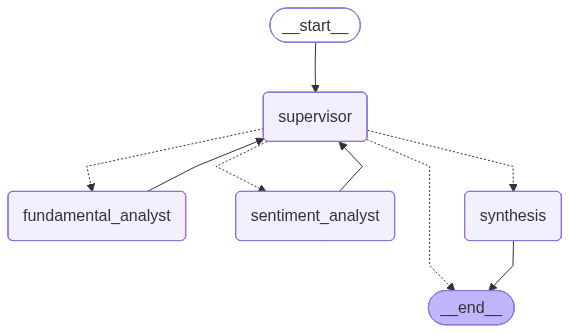

In [145]:
from IPython.display import Image, display

# You could see the errors with the below command
Image(app.get_graph().draw_mermaid_png())

In [146]:
# Define your initial input
input_data = {
    "ticker": "AAPL",
    "messages": [],
    "current_step": "supervisor", # Start at your entry point
    "is_debated": False
}

# Invoke the graph
final_state = app.invoke(
    {"ticker": "AAPL", "current_step": "supervisor"}, 
    config={"recursion_limit": 10}
)
# Print the results
print("--- Final State ---")
from IPython.display import display, Markdown



tools result {'pe_ratio': 34.404552, 'debt_to_equity': 102.63, 'revenue_growth': 0.157}
 fundamental data ### Apple Inc. (AAPL) Fundamental Analysis

1. **P/E Ratio (Price-to-Earnings Ratio)**:
   - **Value**: 34.40
   - **Analysis**: A P/E ratio of 34.40 suggests that investors are willing to pay $34.40 for every $1 of earnings Apple generates. This is relatively high, indicating investor expectations for future growth. However, it may also suggest that the stock could be overvalued compared to its earnings.

2. **Debt-to-Equity Ratio**:
   - **Value**: 102.63%
   - **Analysis**: A debt-to-equity ratio of 102.63 indicates that Apple uses a significant amount of debt financing compared to equity. While this level of leverage can enhance returns, it also introduces increased risk, especially during economic downturns. Apple's robust cash flow management and global market position typically mitigate these risks, but it's a factor to consider.

3. **Revenue Growth**:
   - **Value**: 15.7%

In [147]:
display(Markdown(final_state.get("messages")[-1]))

### Recommendation for Apple Inc. (AAPL)

**_Hold_**

#### Rationale:

Apple Inc. presents a mixed investment profile with both opportunities and risks:

1. **Strong Growth Potential**: 
   - The high P/E ratio suggests optimism in the market about Apple's future earnings, supported by its robust revenue growth of 15.7%. This indicates successful strategies in product innovation and market expansion.

2. **Leverage Risk**: 
   - The debt-to-equity ratio of 102.63% highlights significant debt levels, introducing risk, especially if market conditions deteriorate. While Apple has strong cash flows and market leadership to offset this, it remains a concern.

3. **Neutral Market Sentiment**:
   - Current neutral market sentiment and technical indicators, such as the RSI at 46.69, suggest that the stock might remain static until new information, such as product releases or financial updates, surfaces.

In conclusion, while Apple demonstrates strong financial health and potential for future growth, the relatively high valuation and leverage warrant a cautious approach. Investors should consider keeping their positions stable in anticipation of new data or developments that could impact the stock's trajectory.